In [1]:
# Imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import copy
import pvlib
from jupyterthemes import jtplot

jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [2]:
weather = pd.read_csv('heathrowdata.csv', delim_whitespace=True) 
weather

,yyyy,mm,tmax,tmin,af,rain,sun
0,1948,1,8.9,3.3,---,85.0,---
1,1948,2,7.9,2.2,---,26.0,---
2,1948,3,14.2,3.8,---,14.0,---
3,1948,4,15.4,5.1,---,35.0,---
4,1948,5,18.1,6.9,---,57.0,---
...,...,...,...,...,...,...,...
870,2020,7,23.8,13.4,0,35.2,171.2
871,2020,8,25.6,15.6,0,58.2,161.8
872,2020,9,21.6,11.2,0,20.0,168.9
873,2020,10,15.0,8.8,0,142.2,51.6


In [3]:
class houseEnergySim:
    innerTemp = 0 # C
    airTemp = 0 # C
    groundTemp = 0 # C
    
    def __init__(self):
        self.surfaces = {}
        self.lighting = {}
        self.appliances = {}
        pass
    
    def addSurface(self, name, area, h, ground = False):
        self.surfaces[name] = [area, h, ground]
        
    def getSurfaceHeatTransfer(self, name):
        a = self.surfaces[name][0]
        h = self.surfaces[name][1]
        
        T_1 = self.innerTemp
        T_2 = self.airTemp
        if self.surfaces[name][2]:
            T_2 = self.groundTemp
            
        heatTransfer = (T_1 - T_2) * h * a
        return heatTransfer
    
    def getAllSurfaceHeatTransfer(self):
        heat_transfers = {}
        for surface_name in self.surfaces:
            heat_transfers[surface_name] = self.getSurfaceHeatTransfer(surface_name)
        
        return heat_transfers
    
    def getTotalSurfaceHeatTransfer(self):
        heat_transfer = 0
        for surface_name in self.surfaces:
            heat_transfer += self.getSurfaceHeatTransfer(surface_name)
        
        return heat_transfer
    
    # Times are in 24 hour
    def addLighting(self, name, wattage, ontime, offtime):
        self.lighting[name] = [wattage, ontime, offtime]
    
    def getLightingDaily(self):
        watt_hours = 0
        for light_name in self.lighting:
            light = self.lighting[light_name]
            watt_hours += light[0] * (light[2] - light[1])
        
        return watt_hours
    
    def getLightingHour(self, hour):
        watt_hours = 0
        for light_name in self.lighting:
            light = self.lighting[light_name]
            
            if hour >= light[1] and hour < light[2]:
                watt_hours += light[0]
        
        return watt_hours
    
    # Times are in 24h
    def addAppliance(self, name, wattage, ontime, offtime):
        self.appliances[name] = [wattage, ontime, offtime]
        
    def addApplianceAverage(self, name, wattage, useTime, ontime, offtime):
        self.appliances[name] = [(wattage*useTime)/(offtime - ontime), ontime, offtime]
    
    def getApplianceDaily(self):
        watt_hours = 0
        for appliance_name in self.appliances:
            appliance = self.appliances[appliance_name]
            watt_hours += appliance[0] * (appliance[2] - appliance[1])
        
        return watt_hours
    
    def getApplianceHour(self, hour):
        watt_hours = 0
        for appliance_name in self.appliances:
            appliance = self.appliances[appliance_name]
            
            if hour >= appliance[1] and hour < appliance[2]:
                watt_hours += appliance[0]
        
        return watt_hours

In [4]:
-1%24

23

Carbon neutral housing defs: https://www.thenbs.com/knowledge/will-we-ever-achieve-zero-carbon-homes

http://www.puravent.co.uk/Guide_Resources/AppendixA_UValues.pdf

http://www.virtualmaths.org/activities/topic_data-handling/heatloss/resources/thermal-conductivity-of-building-materials.pdf

$h_{\text{walls}} = \left(\frac{1}{10} + \frac{0.3}{0.6} + \frac{1}{30}\right)^{-1}$

## Setting Thermal Conductivity and Material U values

In [26]:
therm_cond = {"Brickwork outer": 0.77,
              "Brickwork inner": 0.56,
              "Concrete tiles": 1.5,
               "EPS board": 0.04,
               "Polyurethane board": 0.025,
               "Cast concrete": 1.35,
               "Timber": 0.13,
               "Roof tile": 0.84
             }

U_val = {"Single glaze": 4.8, # Assuming wooden frames
        "Double glaze, Air, 12mm": 2.8,
        "Double glaze, Air, Low-E, 12mm": 2.2, # En = 0.15
        "Triple glaze, 12mm": 2.1,
        "Uninsulated brick wall": 1/(1/30 + 1/therm_cond["Brickwork outer"] * 0.15 + 1/therm_cond["Brickwork inner"]*0.15 + 1/10),
        "EPS insulated brick wall": 1/(1/30 + 1/therm_cond["Brickwork outer"] * 0.15 + 1/therm_cond["EPS board"] * 0.04 + 1/therm_cond["Brickwork inner"]*0.15 + 1/10),
        "Timber + Concrete floor": 1/(1/therm_cond["Cast concrete"]*0.5 + 1/therm_cond["Timber"]*0.2 + 1/10),
        "Insulated Timber + Concrete floor": 1/(1/therm_cond["Cast concrete"]*1 + 0.15 + 1/therm_cond["EPS board"] * 0.04 + 1/therm_cond["Timber"]*0.2 + 1/10),
        "Insulated Tile roof": 1/(1/30 + 1/therm_cond["Roof tile"] * 0.05 + 0.15 + 1/therm_cond["EPS board"] * 0.1 + 1/10)
        }

U_val

{'Single glaze': 4.8,
 'Double glaze, Air, 12mm': 2.8,
 'Double glaze, Air, Low-E, 12mm': 2.2,
 'Triple glaze, 12mm': 2.1,
 'Uninsulated brick wall': 1.6778645360450337,
 'EPS insulated brick wall': 0.6265681155489252,
 'Timber + Concrete floor': 0.49780173025102825,
 'Insulated Timber + Concrete floor': 0.2833501513622603,
 'Insulated Tile roof': 0.3517587939698492}

## House 1
Minimal insulation

Appliance usage numbers: 
https://www.cse.org.uk/advice/advice-and-support/how-much-electricity-am-i-using

In [6]:
house1 = houseEnergySim()


### ---Heating---
house1.innerTemp = 20 # C
house1.airTemp = 0 # C
house1.groundTemp = 0 # C

# Walls
house1.addSurface("Exposed walls", 80.6, U_val["Uninsulated brick wall"])
# Basement walls
house1.addSurface("Underground walls", 10.9, U_val["Uninsulated brick wall"], True)
# Floors
house1.addSurface("Floors", 16.15, U_val["Timber + Concrete floor"], True)
# Windows
house1.addSurface("Windows", 16.06, U_val["Single glaze"])
# Roof
house1.addSurface("Roof", 60.84, U_val["Insulated Tile roof"])

### --Lighting---

# 2x 40W bulbs on during the evening
house1.addLighting("Kitchen evening", 2 * 20, 16, 23)
# 4x 40W bulbs on during the evening
house1.addLighting("Bedrooms", 4 * 40, 17, 24)
house1.addLighting("Bedrooms, morning", 4 * 40, 7, 9)
# 2x 20W bulbs turned on for a total of 120 min during the day
house1.addLighting("Bathrooms", 2 * 20/12, 0, 24)

### --Appliances---

# 2 runs of the washing machine, once in the morning and once in the evening
house1.addAppliance("Washing Machine - Load 1", 500, 9, 10)
house1.addAppliance("Washing Machine - Load 2", 500, 18, 19)
# Dishwasher running in the evening
house1.addAppliance("Dishwasher", 100, 21, 23)
# Oven on for 1 hour in the evening
house1.addAppliance("Oven - Dinner", 2000, 20, 21)
# Hob on for 1 hour over lunch, 1 hour over dinner
house1.addAppliance("Hob - Lunch", 2000, 11, 12)
house1.addAppliance("Hob - Dinner", 2000, 20, 21)
# Microwave on for 15 mins at lunch
house1.addApplianceAverage("Microwave - Lunch", 700, 0.25, 11, 12)
# Kettle being run for a total of 30 mins over the day
house1.addApplianceAverage("Kettle (avg)", 3000, 0.5, 9, 22)
# Toaster being run for 10 min at breakfast and lunch
house1.addApplianceAverage("Toaster - breakfast", 800, 0.16, 9, 10)
house1.addApplianceAverage("Toaster - lunch", 800, 0.16, 12, 13)
# Fridge/Freezer on all day
house1.addAppliance("Fridge", 300, 0, 23)
# 4 x laptops on pretty much all day (working from home!)
house1.addAppliance("Laptops", 100 * 4, 9, 22)
# 3 10min showers in the morning, 1 10 min in the evening
house1.addApplianceAverage("Showers - morning", 8000, 0.45, 9, 10)
house1.addApplianceAverage("Showers - evening", 8000, 0.25, 22,23)

# KWh per year sanity check (to be compared against national average)
print("Yearly lighting average: " + str((house1.getLightingDaily() * 365)/1000) + "kWh")
print("Daily appliance average: " + str(house1.getApplianceDaily()/1000) + "kWh")
print("Yearly appliance average: " + str((house1.getApplianceDaily() * 365)/1000) + "kWh")

Yearly lighting average: 657.0kWh
Daily appliance average: 26.831kWh
Yearly appliance average: 9793.315kWh


In [7]:
house1.getApplianceHour(22)

2400.0

## House 2
Much insulation!

In [136]:
house2 = copy.deepcopy(house1)

house2.innerTemp = 20 # C
house2.airTemp = -10 # C
house2.groundTemp = -10 # C

U_walls = U_val["EPS insulated brick wall"]
house2.addSurface("Exposed walls", 80.6, U_walls)

U_underwalls = U_val["EPS insulated brick wall"]
house2.addSurface("Underground walls", 10.9, U_underwalls, True)

U_floor = U_val["Insulated Timber + Concrete floor"]
house2.addSurface("Floors", 16.15, U_floor, True)

U_windows = U_val["Triple glaze, 12mm"]
house2.addSurface("Windows", 16.06, U_windows)

U_roof = U_val["Insulated Tile roof"]
house2.addSurface("Roof", 60.84, U_roof)

house2.getAllSurfaceHeatTransfer()

{'Exposed walls': 1515.041703397301,
 'Underground walls': 204.88777378449853,
 'Floors': 137.2831483350151,
 'Windows': 1011.78,
 'Roof': 642.0301507537688}

## PV system simulation
Using `pvlib`

### Inverter:
Using ABB UNO-DM 6.0 (6kWh)
https://www.fimer.com/single-phase/uno-dm-60-tl-plus-q

### Pannels:
Panasonic HIT VBHN330SA15
https://www.renugen.co.uk/content/Solar_Panel_Brochures_part_3/Solar%20Panel%20Brochures%20part%203/panasonic_brochure/Panasonic-VBHN330SA15-330-Watt-Solar-Panel-Module-Brochure.pdf

https://www.thenbs.com/knowledge/what-is-a-u-value-heat-loss-thermal-mass-and-online-calculators-explained#:~:text=Thermal%20transmittance%2C%20also%20known%20as,the%20U%2Dvalue%20will%20be.


Roof has $33 m^2$ of space, each pannel takes up $1.05m x 1.59m = 1.67m^2$ meaning you can fit roughly $20$ pannels on the roof.

### Google maps link to house
https://www.google.co.uk/maps/@51.4737465,-0.1918266,21z

In [148]:
from pvlib.pvsystem import PVSystem
from pvlib.location import Location
from pvlib.modelchain import ModelChain
from pvlib.location import Location

naive_times = pd.date_range(start='2015', end='2016', freq='1h')

# Model specs setup
sandia_modules = pvlib.pvsystem.retrieve_sam('cecmod')
sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
module = sandia_modules['SANYO_ELECTRIC_CO_LTD_OF_PANASONIC_GROUP_VBHN330SA15']
inverter = sapm_inverters['ABB__UNO_DM_6_0_TL_PLUS_US_SZM_RA__240V_']
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

london = Location(52.475, -0.1916, name="97 Wandsworth Bridge Rd")

system = PVSystem(module_parameters=module,
                  inverter_parameters=inverter,
                  surface_tilt=40,
                  surface_azimuth=175,
                  modules_per_string=20,
                  temperature_model_parameters=temperature_model_parameters)

### Example simulation

https://pvlib-python.readthedocs.io/en/stable/clearsky.html



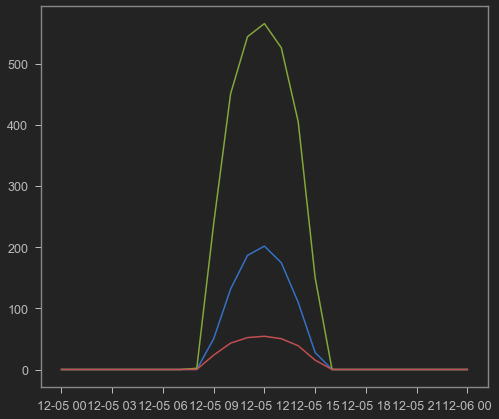

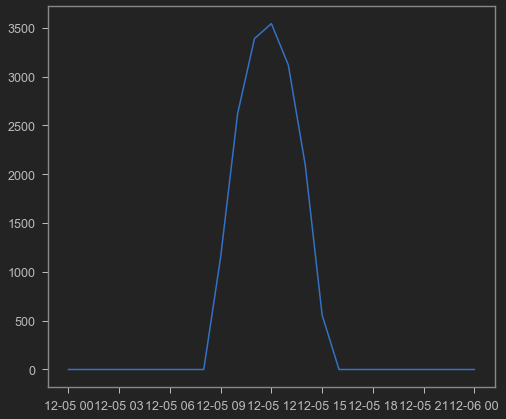

In [180]:
times = pd.date_range(start='2020-12-05', end='2020-12-06', freq='H', tz=london.tz)
clearsky = london.get_clearsky(times)
plt.plot(clearsky)
plt.show()

mc = ModelChain(system, london, orientation_strategy="None", aoi_model="physical", spectral_model="no_loss")
mc.run_model(clearsky)
plt.plot(mc.ac)


## Yearly PV yield

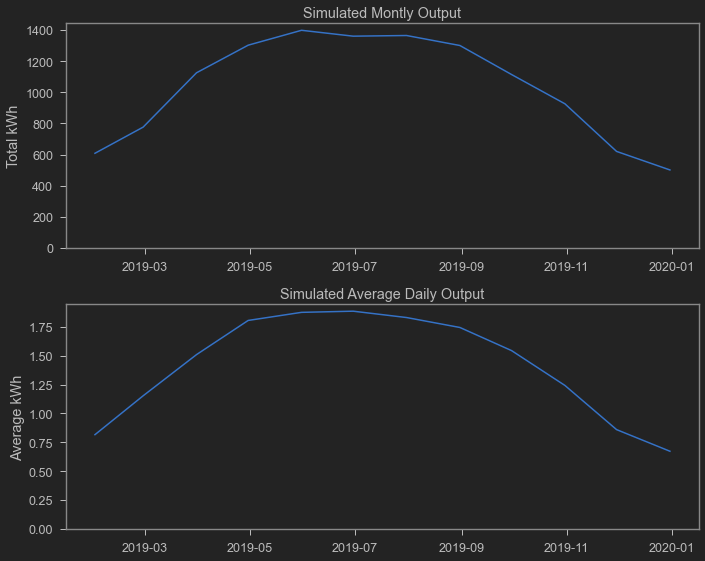

In [150]:
months = pd.date_range(start='2019', end='2020', freq='M')
monthly_vals = []
daily_avg = []

for month_offset in range(1,12):
    times = pd.date_range(start='2019-'+str(month_offset)+'-01', end='2019-'+str(month_offset+1)+'-01', freq='H')
    clearsky = london.get_clearsky(times)
    
    model_sim = mc.run_model(clearsky)
    monthly_vals.append(mc.ac.sum())
    daily_avg.append(mc.ac.sum() / len(times))

times = pd.date_range(start='2019-12-01', end='2020-01-01', freq='H')
clearsky = london.get_clearsky(times)

model_sim = mc.run_model(clearsky)
monthly_vals.append(mc.ac.sum())
daily_avg.append(mc.ac.sum() / len(times))

monthly_vals = np.array(monthly_vals)
daily_avg = np.array(daily_avg)

fig, ax = plt.subplots(2,1, figsize = (10,8))

ax[0].plot(months,monthly_vals/1000)
ax[0].set_ylabel("Total kWh")
ax[0].set_title("Simulated Montly Output")
ax[0].set_ylim(0)

ax[1].plot(months,daily_avg/1000)
ax[1].set_title("Simulated Average Daily Output")
ax[1].set_ylabel("Average kWh")
ax[1].set_ylim(0)

plt.tight_layout()
plt.show()

## Day sim
To check solar and battery output

Somewhat matches https://www.solarchoice.net.au/blog/how-do-i-use-electricity-throughout-the-day-the-load-curve/

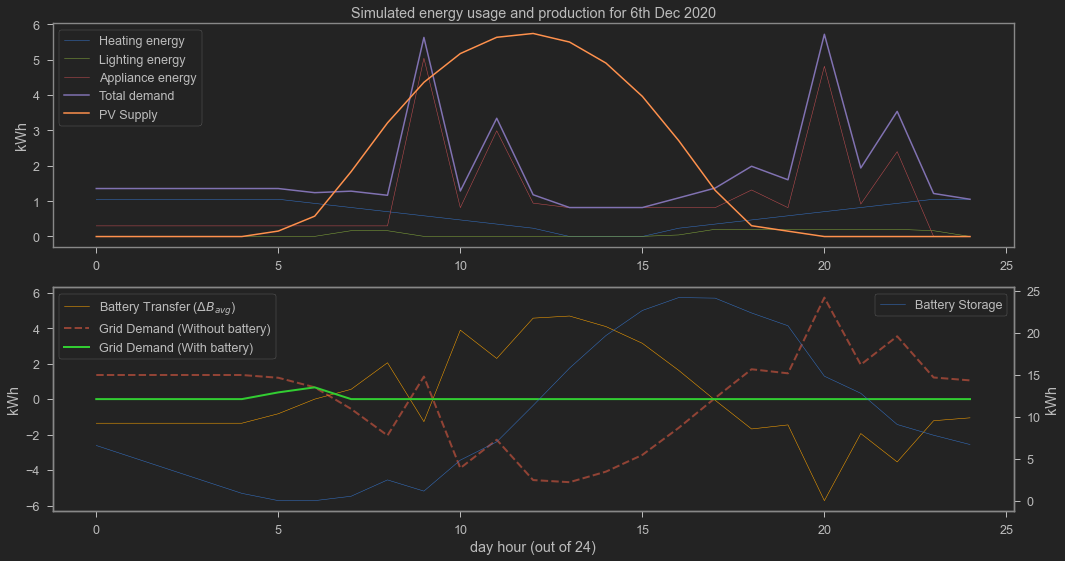

In [270]:
# "Average winter day" (sun 6th of dec)
dailyTemps = []
dailyTemps = [11,11,11,11,11,11,12,13,14,15,16,17,18,20,20,20,18,17,16,15,14,13,12,11,11,11]

heat_transfer1 = []
lighting = []
appliance = []

current_battery_val = 8000
delta_B_vals = []
battery_storage = []

sim_house = house2

# Solar sim
times = pd.date_range(start='2020-6-05', end='2020-6-06', freq='H', tz=london.tz)
clearsky = london.get_clearsky(times)
#plt.plot(clearsky)
#plt.show()

mc = ModelChain(system, london, orientation_strategy="None", aoi_model="physical", spectral_model="no_loss")
mc.run_model(clearsky)
#plt.plot(mc.ac)

solar_power = mc.ac.values

battery_max = 2 * 13.5 * 1000 # Wh, taken from 2x Tesla Power Walls


for hour in range(0, 25):
    sim_house.airTemp = dailyTemps[hour]
    sim_house.groundTemp = dailyTemps[hour]
    
    heat_transfer_val = sim_house.getTotalSurfaceHeatTransfer()
    lighting_val = sim_house.getLightingHour(hour)
    appliance_val = sim_house.getApplianceHour(hour)
    
    heat_transfer1.append(heat_transfer_val)
    lighting.append(lighting_val)
    appliance.append(appliance_val)
    
    demand = heat_transfer_val + lighting_val + appliance_val
    delta_B = solar_power[hour] - demand
    
    # "Use up" the rest of the battery if the next timestep will result in depletion
    if current_battery_val + 1.05*delta_B <= 0:
        delta_B = -0.95*current_battery_val
    
    # Fill to max capacity
    if current_battery_val + 0.95*delta_B >= battery_max:
        delta_B = battery_max -1.05*current_battery_val
    
    # If the next timestep will result in a positve battery value
    if current_battery_val + delta_B >= 0:
        # If charging
        if delta_B > 0:
            current_battery_val += 0.95*delta_B
        if delta_B < 0:
            current_battery_val += 1.05*delta_B
    
    delta_B_vals.append(delta_B)
    battery_storage.append(current_battery_val)
    
    #print(hour)
    
heat_transfer1 = np.array(heat_transfer1)/1000
lighting = np.array(lighting)/1000
appliance = np.array(appliance)/1000
solar_power = np.array(solar_power)/1000
delta_B_vals = np.array(delta_B_vals)/1000
battery_storage = np.array(battery_storage)/1000

fig, ax = plt.subplots(2, 1, figsize = (15,8))
ax[0].set_title("Simulated energy usage and production for 6th Dec 2020")

ax[0].plot(heat_transfer1, label="Heating energy", linewidth = 0.5)
ax[0].plot(lighting, label="Lighting energy", linewidth = 0.5)
ax[0].plot(appliance, label="Appliance energy", linewidth = 0.5)
ax[0].plot(heat_transfer1+lighting+appliance, label="Total demand")
ax[0].plot(solar_power, label="PV Supply")

ax[0].set_ylabel('kWh')
ax[0].legend()

ax2 = ax[1].twinx()

ax2.plot(battery_storage, label="Battery Storage", linewidth=0.5)
ax2.set_ylabel('kWh')
ax2.legend()
ax2.ylim

ax[1].plot(delta_B_vals, label="Battery Transfer ($\Delta B_{avg}$)",color = 'orange', linewidth=0.5)
ax[1].plot(heat_transfer1+lighting+appliance-solar_power, color='tomato', linewidth=2, label="Grid Demand (Without battery)", linestyle='dashed', alpha=0.5)
ax[1].plot(heat_transfer1+lighting+appliance-solar_power+delta_B_vals, color='limegreen', label="Grid Demand (With battery)", linewidth=2)
ax[1].set_xlabel('day hour (out of 24)')
ax[1].set_ylabel('kWh')
ax[1].legend()

fig.tight_layout()
plt.show()

In [187]:
len(heat_transfer1)

24

## Year sim
To graph heating energy

https://www.metoffice.gov.uk/research/climate/maps-and-data/historic-station-data

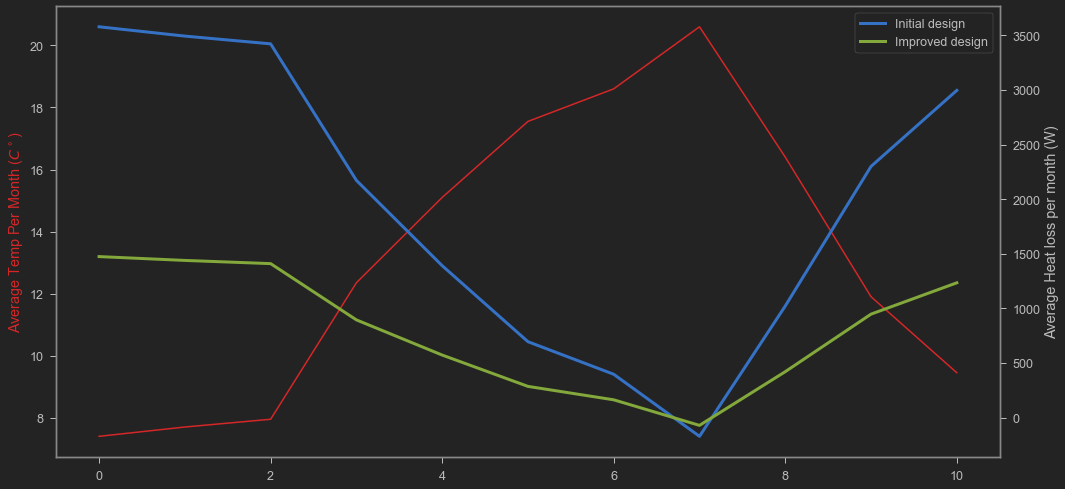

In [260]:
weather2020 = weather[weather['yyyy'].astype(float) > 2019]
avgTemp = (weather2020['tmax'].astype(float) + weather2020['tmin'].astype(float))/2

heat_transfer1 = []
heat_transfer2 = []

for temp in avgTemp:
    house1.airTemp = temp
    house1.groundTemp = temp
    
    heat_transfer1.append(house1.getTotalSurfaceHeatTransfer())
    
    house2.airTemp = temp
    house2.groundTemp = temp
    
    heat_transfer2.append(house2.getTotalSurfaceHeatTransfer())

fig, ax1 = plt.subplots(figsize = (15,7))

color = 'tab:red'
ax1.set_ylabel('Average Temp Per Month ($C^\circ$)', color = color)
ax1.plot(avgTemp.values, color = color)

ax2 = ax1.twinx()
ax2.set_xlabel("Month Num")
ax2.set_ylabel('Average Heat loss per month (W)')

ax2.plot(heat_transfer1, label = "Initial design", linewidth = 3)
ax2.plot(heat_transfer2, label = "Improved design", linewidth = 3)

ax2.legend()

fig.tight_layout()
plt.show()

In [13]:
heat_transfer1

[3577.876923227016,
 3492.6893774358964,
 3421.699755943297,
 2172.2824176735453,
 1391.3965812549502,
 695.6982906274751,
 397.54188035855685,
 -170.37509158223926,
 1022.2505494934334,
 2300.063736360224,
 2995.7620269877]